In [1]:
#import dependencies
import subprocess
import sys

import pandas as pd 
import polyclonal
import numpy as np

from scipy.spatial.distance import cdist


In [2]:
#standard formatting rules

colspecs = [(0, 6), (6, 11), (12, 16), (16, 17), (17, 20), (21, 22), (22, 26),
            (26, 27), (30, 38), (38, 46), (46, 54), (54, 60), (60, 66), (76, 78),
            (78, 80)]

names = ['ATOM', 'serial', 'name', 'altloc', 'resname', 'chainid', 'resseq',
         'icode', 'x', 'y', 'z', 'occupancy', 'tempfactor', 'element', 'charge']

valid_residues = ['GLN', 'VAL', 'THR', 'LEU', 'GLU',
       'ALA', 'PHE', 'SER', 'LYS', 'TYR', 'GLY', 'PRO', 'CYS', 'ASN',
       'ARG', 'TRP', 'MET', 'ILE', 'ASP', 'HIS'];


In [3]:
def format_PDB_df(df):
    pdb = df.copy();

    #prefilter for only valid residues and nan values
    pdb = pdb[pdb['resname'].isin(valid_residues)];
    pdb = pdb[pdb['element'].isna()==False];
    
    #only accept atoms
    pdb = pdb[pdb['ATOM']=='ATOM'];
    
    #convert residue sequence number to an integer
    pdb['resseq'] = pdb['resseq'].apply(lambda x: int(x))
    pdb['x']=pdb['x'].apply(lambda x: float(x))
    pdb['y']=pdb['y'].apply(lambda x: float(x))
    pdb['z']=pdb['z'].apply(lambda x: float(x))

    return pdb




input_pdb_file = '../data/PDB_Structures/8r40.pdb'
pdb = pd.read_fwf(input_pdb_file, names=names, colspecs=colspecs);
pdb = format_PDB_df(pdb)


#get chains of interest (varies from structure to structure)
CR57= ['A','R'];
G =['G'];

#save separately
G_coord = pdb[pdb['chainid'].isin(G)];
CR57_coord = pdb[pdb['chainid'].isin(CR57)];


In [4]:
#define a function that takes a grouped dataframe, calculates all distances from antibody and saves minimum distance. This is on a per-residue level.
#this is really inelegant, but i'll just scroll through all residues since we might want information on escape for distant sites.
def calculate_min_distance(G,antibody):
    # Extract the coordinates (x, y, z) from the dataframes as numpy arrays
    coords1 = G[['x', 'y', 'z']].to_numpy();
    coords2 = antibody[['x', 'y', 'z']].to_numpy();
    # Compute pairwise distances between points in df1 and df2 using Euclidean distance
    distances = cdist(coords1, coords2, metric='euclidean');
    # Find the minimum distance across all pairs of points 
    min_distance = distances.min()

    # Save the minimum distance as a new single entry in df1 (e.g., as a single value for the entire df1)
    return min_distance





In [5]:
# Group by 'resseq' and apply the function to each group
# Instead of resetting index, we'll merge the results back correctly
min_distances = G_coord.groupby('resseq').apply(lambda group: calculate_min_distance(group, CR57_coord))

# Assign the minimum distance value to the corresponding rows in df_large
G_coord['min_distance'] = G_coord['resseq'].map(min_distances)

/tmp/ipykernel_38623/2670167719.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_distances = G_coord.groupby('resseq').apply(lambda group: calculate_min_distance(group, CR57_coord))
/tmp/ipykernel_38623/2670167719.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  G_coord['min_distance'] = G_coord['resseq'].map(min_distances)


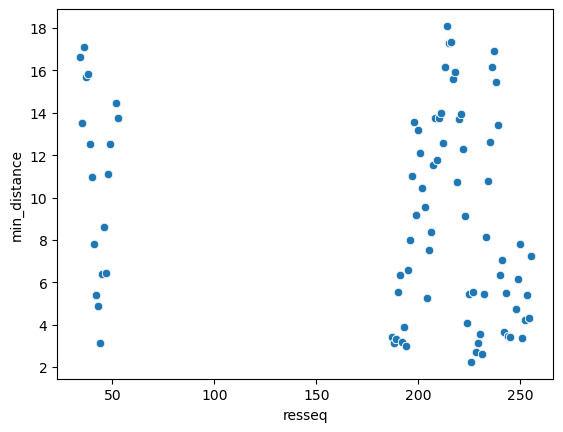

In [6]:
import seaborn as sb
from matplotlib import pyplot as pl

sb.scatterplot(data=G_coord, x='resseq',y='min_distance')
pl.show()



In [7]:
G_coord[G_coord['min_distance']<=4].resseq.unique()

array([ 44, 187, 188, 189, 192, 193, 194, 226, 228, 229, 230, 231, 242,
       244, 245, 251])

## 17C7

In [9]:
input_pdb_file = '../data/PDB_Structures/8a1e.pdb'


pdb = pd.read_fwf(input_pdb_file, names=names, colspecs=colspecs);


pdb = format_PDB_df(pdb)


In [10]:
#get chains of interest (varies from structure to structure)
Antibody= ['D','E'];
G =['A'];

In [11]:
#save separately

G_coord = pdb[pdb['chainid'].isin(G)];
antibody_coord = pdb[pdb['chainid'].isin(Antibody)];

/tmp/ipykernel_38623/187561361.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_distances = G_coord.groupby('resseq').apply(lambda group: calculate_min_distance(group, antibody_coord))
/tmp/ipykernel_38623/187561361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  G_coord['min_distance'] = G_coord['resseq'].map(min_distances)


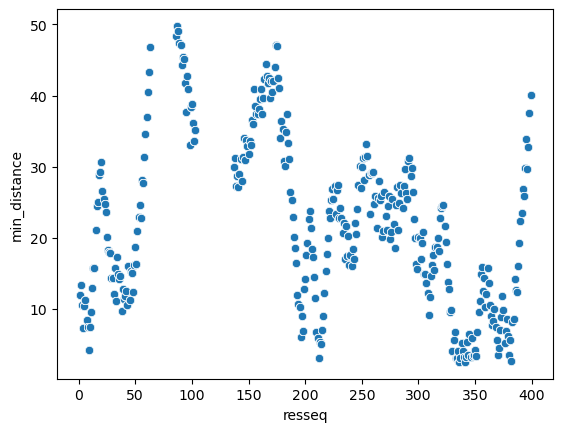

In [12]:
# Group by 'resseq' and apply the function to each group
# Instead of resetting index, we'll merge the results back correctly
min_distances = G_coord.groupby('resseq').apply(lambda group: calculate_min_distance(group, antibody_coord))

# Assign the minimum distance value to the corresponding rows in df_large
G_coord['min_distance'] = G_coord['resseq'].map(min_distances)


#just plot a trace of the distances to see if it makes sense
sb.scatterplot(data=G_coord, x='resseq',y='min_distance')
pl.show()

In [13]:
G_coord[G_coord['min_distance']<=4].resseq.unique()

array([212, 333, 334, 336, 337, 340, 341, 342, 344, 346, 348, 349, 351,
       370, 380, 382])

## RVA122

In [14]:
input_pdb_file = '../data/PDB_Structures/7u9g.pdb'


pdb = pd.read_fwf(input_pdb_file, names=names, colspecs=colspecs);


pdb = format_PDB_df(pdb)


In [15]:
#get chains of interest (varies from structure to structure)
Antibody= ['F','I'];
G =['A'];

In [16]:
#save separately

G_coord = pdb[pdb['chainid'].isin(G)];
antibody_coord = pdb[pdb['chainid'].isin(Antibody)];

/tmp/ipykernel_38623/187561361.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_distances = G_coord.groupby('resseq').apply(lambda group: calculate_min_distance(group, antibody_coord))
/tmp/ipykernel_38623/187561361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  G_coord['min_distance'] = G_coord['resseq'].map(min_distances)


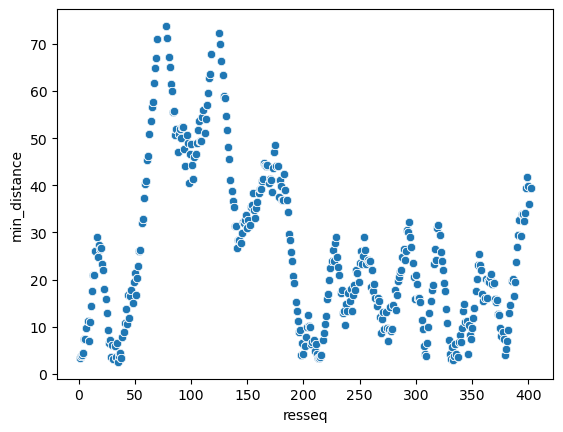

In [17]:
# Group by 'resseq' and apply the function to each group
# Instead of resetting index, we'll merge the results back correctly
min_distances = G_coord.groupby('resseq').apply(lambda group: calculate_min_distance(group, antibody_coord))

# Assign the minimum distance value to the corresponding rows in df_large
G_coord['min_distance'] = G_coord['resseq'].map(min_distances)


#just plot a trace of the distances to see if it makes sense
sb.scatterplot(data=G_coord, x='resseq',y='min_distance')
pl.show()

In [18]:
G_coord[G_coord['min_distance']<=4].resseq.unique()

array([  1,   2,   3,  29,  31,  33,  35,  36,  38, 198, 213, 214, 215,
       216, 309, 331, 333, 334, 337])

## RVC20

In [ ]:
input_pdb_file = 'data/PDB_Structures/6tou.pdb'


pdb = pd.read_fwf(input_pdb_file, names=names, colspecs=colspecs);


pdb = format_PDB_df(pdb)

In [ ]:
#get chains of interest (varies from structure to structure)
Antibody= ['A'];
G =['G'];

In [ ]:
#save separately

G_coord = pdb[pdb['chainid'].isin(G)];
antibody_coord = pdb[pdb['chainid'].isin(Antibody)];

In [ ]:
# Group by 'resseq' and apply the function to each group
# Instead of resetting index, we'll merge the results back correctly
min_distances = G_coord.groupby('resseq').apply(lambda group: calculate_min_distance(group, antibody_coord))

# Assign the minimum distance value to the corresponding rows in df_large
G_coord['min_distance'] = G_coord['resseq'].map(min_distances)


#just plot a trace of the distances to see if it makes sense
sb.scatterplot(data=G_coord, x='resseq',y='min_distance')
pl.show()

In [ ]:
G_coord[G_coord['min_distance']<=4].resseq.unique()